In [1]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from utils import *
import shap
import seaborn as sns
from tqdm import tqdm
import pingouin as pg
import pandas as pd
import scipy
import statannot

/home/xiaowei/miniconda3/envs/bci/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

main_path = '/data/xiaowei/social_network/HENU/'
def get_fake_epoch(folder_name,main_path,model_type):
    epoch = loadpkl(main_path + 'preprocessing/' + folder_name + '/final_eye_close_1001_epoch_concat.pkl')
    return epoch
def draw_topo(folder_name,main_path,model_type):
    epoch = loadpkl(main_path + 'preprocessing/' + folder_name + '/final_eye_close_1001_epoch_concat.pkl')
    psd_r2_path = main_path + 'EEG_regression/' + folder_name + f'/{model_type}_r2_score.csv'
    psd_r2 = pd.read_csv(psd_r2_path, index_col=0, header=0)
    evoke = epoch['T'].copy().average()

    fig = plt.figure(figsize=(32, 10))
    fig.suptitle(f'{folder_name} {model_type}', fontsize=20)
    axes = {}
    key_index_list = ['final_eye_close_PSD_CH','final_eye_open_PSD_CH','midterm_eye_close_PSD_CH','midterm_eye_open_PSD_CH']
    for i, key_index in enumerate(key_index_list):
        plt.subplot(1,len(key_index_list), i+1)
        evoke._data = np.stack([psd_r2['value'][key_index+str(i)] for i in range(31)]).reshape(-1,1).repeat(evoke._data.shape[1], axis=1)*1e-6
        mne.viz.plot_topomap(data =  np.stack([psd_r2['value'][key_index+str(i)] for i in range(31)]),
                             pos = epoch.info,
                             names = epoch.info['ch_names'],show_names = True,
                             vmin = 0.35,
                             vmax = 0.5,
                             cmap = 'jet',show = False,
                             )
        plt.title(key_index, fontdict={'fontsize': 30})
    plt.savefig(main_path + f'EEG_regression/{model_type}_topo.png')


Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.


In [ ]:
# draw_topo(folder_name = 'S42_C30_330_F4_8_N50_E2_Raverage',main_path = main_path,model_type = 'XGBRegressor')
# draw_topo(folder_name = 'S42_C30_330_F14_30_N50_E2_Raverage',main_path = main_path,model_type = 'XGBRegressor')
# draw_topo(folder_name = 'S42_C30_330_F1_40_N50_E2_Raverage',main_path = main_path,model_type = 'XGBRegressor')
# draw_topo(folder_name = 'C30_330_F8_14_N50_E1.5_Raverage',main_path = main_path,model_type = 'XGBRegressor')
# draw_topo(folder_name = 'C30_330_F8_14_N50_E1_Raverage',main_path = main_path,model_type = 'XGBRegressor')


In [ ]:
df = pd.read_excel('/data/xiaowei/social_network/HENU/data/survey_data/Social_network_V2.xlsx', index_col=0, header=0)

a = df.to_numpy().reshape(-1)

from sklearn.metrics import r2_score
import torch
print(np.unique(a, return_counts=True))
r2 = r2_score(a, np.ones_like(a)*a.mean())
print(r2)
print(1262/np.sum(np.unique(a, return_counts=True)[1]))


In [ ]:
# shap.initjs()
# {'model':model,'X_train':X_train,'X_test':X_test,'y_train':y_train,'y_test':y_test,'X_name':X_name}
from sklearn.metrics import r2_score

folder_name = 'S42_C30_330_F8_14_N50_E2_Raverage'
model_type = 'xgboost'

model_set = loadpkl(main_path + 'statistic/alpha_asymmetry_F'  + f'/{folder_name}_{model_type}_set_model.pkl')

explainer = shap.Explainer(model_set['model'],feature_names=model_set['X_name'][1:])
shap_values = explainer(model_set['X_test'])
print(f"r2 score: {r2_score(model_set['y_test'],model_set['model'].predict(model_set['X_test']))}")
shap.plots.bar(shap_values)

In [ ]:
# shap.initjs()
# {'model':model,'X_train':X_train,'X_test':X_test,'y_train':y_train,'y_test':y_test,'X_name':X_name}
from sklearn.metrics import r2_score

folder_name = 'S42_C30_330_F8_14_N50_E2_Raverage'
model_type = 'xgboost'

model_set = loadpkl(main_path + 'statistic/alpha_asymmetry_F'  + f'/{folder_name}_{model_type}_set_model.pkl')

explainer = shap.Explainer(model_set['model'],feature_names=model_set['X_name'][1:])
shap_values = explainer(model_set['X_test'])
print(f"r2 score: {r2_score(model_set['y_test'],model_set['model'].predict(model_set['X_test']))}")
shap.plots.bar(shap_values)

In [ ]:
# test the best model's performance on the test set
folder_name = 'S42_C30_330_F1_40_N50_E2_Raverage'
Bayes_opt_path = os.path.join(main_path, 'AIO_regression' , folder_name,'XGBRegressor_PSD_187_BayesOpt.pkl')
Data_path = os.path.join(main_path, 'AIO_regression' , folder_name,'XGBRegressor_PSD_187_Dataset.pkl')
Dataset = loadpkl(Data_path)
Bayes_opt_model = loadpkl(Bayes_opt_path)
best_score = Bayes_opt_model.score(Dataset['X_val'],Dataset['y_val'])
print(best_score)

In [3]:
import matplotlib as mpl

def mappshap(shap_values):
    # input: 4836 as Channel from 0 to 30, after freq from 0 to 155
    # output: (31,156,2)
    shap = np.zeros((31,78,2))
    t = 0
    for s in range(2):
        for i in range(31):
            for j in range(78):
                shap[i,j,s] = shap_values[t]
                t += 1
    return shap
folder_name = 'S42_C30_330_F1_40_N50_E2_Raverage'
model_type = 'XGBRegressor'
method = 'PSD'
seed = 187
file_path = '/data/xiaowei/social_network/HENU/figs/fi_value'
if not os.path.exists(file_path): os.makedirs(file_path)
Data = loadpkl(main_path + f'AIO_regression/{folder_name}/'  + f'{model_type}_{method}_{seed}_Dataset.pkl')
model = loadpkl(main_path + f'AIO_regression/{folder_name}/'  + f'{model_type}_{method}_{seed}_model.pkl')

epoch = get_fake_epoch(folder_name = folder_name,main_path = main_path,model_type = model_type)
ch_name = epoch.info['ch_names']
X_test = Data['X_val']
y_test = Data['y_val']
X_key_test = Data['X_key_val']
EEG_featuremap = Data['EEG_featuremap']
EEG_bands = dict(alpha = [8,14],beta = [14,30],theta = [4,8],gamma = [30,40],delta = [1,4])

avg_shap_values_dict = dict()
for term in ['final','midterm']:
    for event in ['eye_close','eye_open']:
        title = f'{folder_name}_{model_type}_{seed}_{method}_{term}_{event}'
        idx = np.isin(X_key_test,f"{term}_{event}_True")+np.isin(X_key_test,f"{term}_{event}_False") != 0
        feature_names_array = np.array(EEG_featuremap[term][event+'_PSD'])[0] # channel+frequency
        feature_names = np.concatenate([np.stack([f"S{subj}_CH{feature_names_array[i][0]:.0f}_F{feature_names_array[i][1]:.2f}" 
                            for i in range(feature_names_array.shape[0])])
                            for subj in ['A','B']])
        psd_idx = np.array(sorted(np.unique(feature_names_array[:,1])))
        explainer = shap.TreeExplainer(model,feature_names=feature_names)
        shap_values = np.abs(explainer.shap_values(X_test[idx]))
        shap_values_organized = np.stack([mappshap(shap_values[i]) for i in range(shap_values.shape[0])])
        avg_shap_values = np.mean(shap_values_organized,axis=0) #(31,78,2)
        avg_shap_values_dict[f"{term}_{event}"] = shap_values_organized
        for ib,band in tqdm(enumerate(EEG_bands.keys()),desc=f'{term}_{event}'):
            idx = (np.array(psd_idx>=EEG_bands[band][0],dtype = np.int32) * np.array(psd_idx<=EEG_bands[band][1],dtype = np.int32)) != 0
            avg_band_shap_values = avg_shap_values[:,idx,::].mean(1) #(31,2)
            for isubj,subj in enumerate(['A','B']):
                fig, ax = plt.subplots(figsize=(10, 10))
                plt.title(f'{subj}_{band}')
                im,cn = mne.viz.plot_topomap(data = avg_band_shap_values[:,isubj],pos = epoch.info,
                                names = epoch.info['ch_names'],show_names = True,
                                vmin = 0,vmax = 0.015,
                                cmap = 'jet',show = False,axes = ax)
                ax_x_start = 0.9
                ax_x_width = 0.04
                ax_y_start = 0.2
                ax_y_height = 0.7
                cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
                clb = fig.colorbar(im, cax=cbar_ax,)               
                plt.savefig(f'{file_path}/{title}_B{band}_S{subj}_shap_topo.png')
                plt.close()


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
final_eye_close: 5it [00:02,  2.30it/s]


KeyboardInterrupt: 

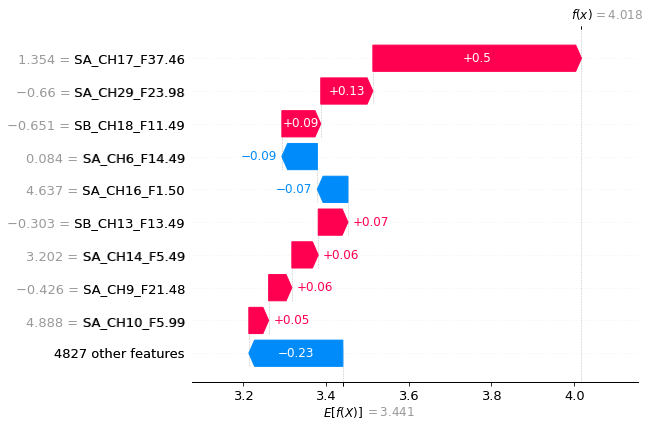

In [11]:
# shap_values = explainer(X_test[idx])
shap.plots.waterfall(shap_values[1],show = False)
plt.savefig(f'shap_waterfall1.png',dpi = 600)

In [ ]:
# ignore all warnings
import warnings
warnings.filterwarnings('ignore')

def pre_processing(data):
    data_new = data.copy()
    # check 
    # data_new = -1/np.log(data.copy())
    return data_new
shap_values_dict = dict()
for key in avg_shap_values_dict.keys():
    shap_values_dict[key] = pre_processing(avg_shap_values_dict[key])


In [ ]:

res = dict()
for ch in range(31):
    for freq in tqdm(range(78),desc = f'Channel {ch}'):
        res[f"{ch}_{freq}"] = {}
        d_f_c_A = shap_values_dict["final_eye_close"][:,ch,freq,0]
        d_f_c_B = shap_values_dict["final_eye_close"][:,ch,freq,1]
        d_f_o_A = shap_values_dict["final_eye_open"][:,ch,freq,0]
        d_f_o_B = shap_values_dict["final_eye_open"][:,ch,freq,1]
        d_m_c_A = shap_values_dict["midterm_eye_close"][:,ch,freq,0]
        d_m_c_B = shap_values_dict["midterm_eye_close"][:,ch,freq,1]
        d_m_o_A = shap_values_dict["midterm_eye_open"][:,ch,freq,0]
        d_m_o_B = shap_values_dict["midterm_eye_open"][:,ch,freq,1]
        dv = np.concatenate([d_f_c_A,d_f_c_B,d_f_o_A,d_f_o_B,d_m_c_A,d_m_c_B,d_m_o_A,d_m_o_B])
        term = np.concatenate([ np.repeat(['final'],d_f_c_A.shape[0]),
                                np.repeat(['final'],d_f_c_B.shape[0]),
                                np.repeat(['final'],d_f_o_A.shape[0]),
                                np.repeat(['final'],d_f_o_B.shape[0]),
                                np.repeat(['midterm'],d_m_c_A.shape[0]),
                                np.repeat(['midterm'],d_m_c_B.shape[0]),
                                np.repeat(['midterm'],d_m_o_A.shape[0]),
                                np.repeat(['midterm'],d_m_o_B.shape[0])
                            ])
                               
        eye = np.concatenate([  np.repeat(['eye_close'],d_f_c_A.shape[0]),
                                np.repeat(['eye_close'],d_f_c_B.shape[0]),
                                np.repeat(['eye_open'],d_f_o_A.shape[0]),
                                np.repeat(['eye_open'],d_f_o_B.shape[0]),
                                np.repeat(['eye_close'],d_m_c_A.shape[0]),
                                np.repeat(['eye_close'],d_m_c_B.shape[0]),
                                np.repeat(['eye_open'],d_m_o_A.shape[0]),
                                np.repeat(['eye_open'],d_m_o_B.shape[0])
                            ])
        subj = np.concatenate([ np.repeat(['A'],d_f_c_A.shape[0]),
                                np.repeat(['B'],d_f_c_B.shape[0]),
                                np.repeat(['A'],d_f_o_A.shape[0]),
                                np.repeat(['B'],d_f_o_B.shape[0]),
                                np.repeat(['A'],d_m_c_A.shape[0]),
                                np.repeat(['B'],d_m_c_B.shape[0]),
                                np.repeat(['A'],d_m_o_A.shape[0]),
                                np.repeat(['B'],d_m_o_B.shape[0])
                            ])
        
        df = pd.DataFrame(dict(dv = dv,term = term,eye = eye,subj = subj))
        stat = pg.anova(df,between = ['term','eye','subj'],dv = 'dv')
        res[f"{ch}_{freq}"]['term_avg'] = df.groupby(by=["term"], dropna=True)['dv'].mean()
        res[f"{ch}_{freq}"]['eye_avg'] = df.groupby(by=["eye"], dropna=True)['dv'].mean()
        res[f"{ch}_{freq}"]['subj_avg'] = df.groupby(by=["subj"], dropna=True)['dv'].mean()
        try:
            res[f"{ch}_{freq}"]['term_p'] = stat['p-unc'].loc[stat['Source']=='term'].values[0]
        except:
            res[f"{ch}_{freq}"]['term_p'] = 1
        try:
            res[f"{ch}_{freq}"]['eye_p'] = stat['p-unc'].loc[stat['Source']=='eye'].values[0]
        except:
            res[f"{ch}_{freq}"]['eye_p'] = 1
        try:
            res[f"{ch}_{freq}"]['term_F'] = stat['F'].loc[stat['Source']=='term'].values[0]
        except:
            res[f"{ch}_{freq}"]['term_F'] = 0
        try:
            res[f"{ch}_{freq}"]['eye_F'] = stat['F'].loc[stat['Source']=='eye'].values[0]
        except:
            res[f"{ch}_{freq}"]['eye_F'] = 0
        try:
            res[f"{ch}_{freq}"]['subj_p'] = stat['p-unc'].loc[stat['Source']=='subj'].values[0]
        except:
            res[f"{ch}_{freq}"]['subj_p'] = 1
        try:
            res[f"{ch}_{freq}"]['subj_F'] = stat['F'].loc[stat['Source']=='subj'].values[0]
        except:
            res[f"{ch}_{freq}"]['subj_F'] = 0
        


In [ ]:
def draw_topo_band(data,title,epoch,file_path,vmin = None,vmax = None):
    if vmin is None: vmin = np.min(data)
    if vmax is None: vmax = np.max(data)
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.title(title)
    im,cn = mne.viz.plot_topomap(data = data,pos = epoch.info,
                        names = epoch.info['ch_names'],show_names = True,
                        vmin = vmin,vmax = vmax,
                        cmap = 'jet',show = False,axes = ax)
    ax_x_start = 0.9
    ax_x_width = 0.04
    ax_y_start = 0.2
    ax_y_height = 0.7
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im, cax=cbar_ax)               
    plt.savefig(file_path)
    plt.close()

def double_check_h_value(h_value,k):
    for a in range(h_value.shape[0]):
        for i in range(h_value.shape[1]-k):
            if np.sum(h_value[a,i-k+1:i+1]) != k:
                if np.sum(h_value[a,i:i+k]) != k:
                    h_value[a,i] = 0
    return h_value
    
term_F = np.zeros((31,78))
eye_F = np.zeros((31,78))
term_p = np.zeros((31,78))
eye_p = np.zeros((31,78))
subj_F = np.zeros((31,78))
subj_p = np.zeros((31,78))
term_h = np.zeros((31,78))
eye_h = np.zeros((31,78))
subj_h = np.zeros((31,78))
final_avg = np.zeros((31,78))
midterm_avg = np.zeros((31,78))
eye_close_avg = np.zeros((31,78))
eye_open_avg = np.zeros((31,78))
A_avg = np.zeros((31,78))
B_avg = np.zeros((31,78))


file_path = '/data/xiaowei/social_network/HENU/figs/fi'
if not os.path.exists(file_path): os.makedirs(file_path)
k = 2
for ch in range(31):
    for freq in range(78):
        term_F[ch,freq] = res[f"{ch}_{freq}"]['term_F']
        eye_F[ch,freq] = res[f"{ch}_{freq}"]['eye_F']
        subj_F[ch,freq] = res[f"{ch}_{freq}"]['subj_F']
        term_p[ch,freq] = res[f"{ch}_{freq}"]['term_p']
        eye_p[ch,freq] = res[f"{ch}_{freq}"]['eye_p']
        subj_p[ch,freq] = res[f"{ch}_{freq}"]['subj_p']
        final_avg[ch,freq] = res[f"{ch}_{freq}"]['term_avg'].loc['final']
        midterm_avg[ch,freq] = res[f"{ch}_{freq}"]['term_avg'].loc['midterm']
        eye_close_avg[ch,freq] = res[f"{ch}_{freq}"]['eye_avg'].loc['eye_close']
        eye_open_avg[ch,freq] = res[f"{ch}_{freq}"]['eye_avg'].loc['eye_open']
        A_avg[ch,freq] = res[f"{ch}_{freq}"]['subj_avg'].loc['A']
        B_avg[ch,freq] = res[f"{ch}_{freq}"]['subj_avg'].loc['B']
        
        # fdr correction for p-values by mne function


        # term_h[ch,freq] = res[f"{ch}_{freq}"]['term_p']<0.05
        # eye_h[ch,freq] = res[f"{ch}_{freq}"]['eye_p']<0.05
        # subj_h[ch,freq] = res[f"{ch}_{freq}"]['subj_p']<0.05

term_h = mne.stats.fdr_correction(term_p)[0]
eye_h = mne.stats.fdr_correction(eye_p)[0]
subj_h = mne.stats.fdr_correction(subj_p)[0]
term_h = double_check_h_value(term_h.copy(),k)
eye_h = double_check_h_value(eye_h.copy(),k)
subj_h = double_check_h_value(subj_h.copy(),k)

for ib,band in enumerate(EEG_bands.keys()):
    idx = (np.array(psd_idx>=EEG_bands[band][0],dtype = np.int32) * np.array(psd_idx<=EEG_bands[band][1],dtype = np.int32)) != 0
    avg_band_term_F = np.mean(term_F[:,idx],axis = 1)
    avg_band_eye_F = np.mean(eye_F[:,idx],axis = 1)
    avg_band_subj_F = np.mean(subj_F[:,idx],axis = 1)
    avg_band_term_p = 1-np.mean(term_p[:,idx],axis = 1)
    avg_band_eye_p = 1-np.mean(eye_p[:,idx],axis = 1)
    avg_band_subj_p = 1-np.mean(subj_p[:,idx],axis = 1)
    avg_band_term_avg = np.mean(final_avg[:,idx],axis = 1)-np.mean(midterm_avg[:,idx],axis = 1)
    avg_band_eye_avg = np.mean(eye_close_avg[:,idx],axis = 1)-np.mean(eye_open_avg[:,idx],axis = 1)
    avg_band_subj_avg = np.mean(A_avg[:,idx],axis = 1)-np.mean(B_avg[:,idx],axis = 1)
    avg_band_term_h = np.mean(term_h[:,idx],axis = 1)
    avg_band_eye_h = np.mean(eye_h[:,idx],axis = 1)
    avg_band_subj_h = np.mean(subj_h[:,idx],axis = 1)

    # draw
    draw_topo_band(avg_band_term_F,f"{band}_term_F",epoch,f"{file_path}/{band}_term_F.png")
    draw_topo_band(avg_band_eye_F,f"{band}_eye_F",epoch,f"{file_path}/{band}_eye_F.png")
    draw_topo_band(avg_band_subj_F,f"{band}_subj_F",epoch,f"{file_path}/{band}_subj_F.png")
    draw_topo_band(avg_band_term_p,f"{band}_term_p",epoch,f"{file_path}/{band}_term_p.png")
    draw_topo_band(avg_band_eye_p,f"{band}_eye_p",epoch,f"{file_path}/{band}_eye_p.png")
    draw_topo_band(avg_band_subj_p,f"{band}_subj_p",epoch,f"{file_path}/{band}_subj_p.png")
    draw_topo_band(avg_band_term_avg,f"{band}_term_avg",epoch,f"{file_path}/{band}_final-midterm.png")
    draw_topo_band(avg_band_eye_avg,f"{band}_eye_avg",epoch,f"{file_path}/{band}_close-open.png")
    draw_topo_band(avg_band_subj_avg,f"{band}_subj_avg",epoch,f"{file_path}/{band}_A-B.png")
    draw_topo_band(avg_band_term_h,f"{band}_term_h",epoch,f"{file_path}/{band}_term_h.png")
    draw_topo_band(avg_band_eye_h,f"{band}_eye_h",epoch,f"{file_path}/{band}_eye_h.png")
    draw_topo_band(avg_band_subj_h,f"{band}_subj_h",epoch,f"{file_path}/{band}_subj_h.png")



In [ ]:
# draw the channel bar plot

file_path = '/data/xiaowei/social_network/HENU/figs/fi_bar_channel'
if not os.path.exists(file_path): os.makedirs(file_path)
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"
for ib,band in enumerate(EEG_bands.keys()):
    for ch in tqdm(range(31),desc = f"{band}_bar"):
        idx = (np.array(psd_idx>=EEG_bands[band][0],dtype = np.int32) * np.array(psd_idx<=EEG_bands[band][1],dtype = np.int32)) != 0
        d_f_c_A = shap_values_dict[f'final_eye_close'][:,ch,idx,0].mean(1)
        d_f_c_B = avg_shap_values_dict[f'final_eye_close'][:,ch,idx,1].mean(1)
        d_f_o_A = avg_shap_values_dict[f'final_eye_open'][:,ch,idx,0].mean(1)
        d_f_o_B = avg_shap_values_dict[f'final_eye_open'][:,ch,idx,1].mean(1)
        d_m_c_A = avg_shap_values_dict[f'midterm_eye_close'][:,ch,idx,0].mean(1)
        d_m_c_B = avg_shap_values_dict[f'midterm_eye_close'][:,ch,idx,1].mean(1)
        d_m_o_A = avg_shap_values_dict[f'midterm_eye_open'][:,ch,idx,0].mean(1)
        d_m_o_B = avg_shap_values_dict[f'midterm_eye_open'][:,ch,idx,1].mean(1)

        dv = np.concatenate([d_f_c_A,d_f_c_B,d_f_o_A,d_f_o_B,d_m_c_A,d_m_c_B,d_m_o_A,d_m_o_B],axis = 0)
        term = np.concatenate([ np.repeat(['final'],d_f_c_A.shape[0]),
                                np.repeat(['final'],d_f_c_B.shape[0]),
                                np.repeat(['final'],d_f_o_A.shape[0]),
                                np.repeat(['final'],d_f_o_B.shape[0]),
                                np.repeat(['midterm'],d_m_c_A.shape[0]),
                                np.repeat(['midterm'],d_m_c_B.shape[0]),
                                np.repeat(['midterm'],d_m_o_A.shape[0]),
                                np.repeat(['midterm'],d_m_o_B.shape[0])
                            ])
                               
        eye = np.concatenate([  np.repeat(['eye_close'],d_f_c_A.shape[0]),
                                np.repeat(['eye_close'],d_f_c_B.shape[0]),
                                np.repeat(['eye_open'],d_f_o_A.shape[0]),
                                np.repeat(['eye_open'],d_f_o_B.shape[0]),
                                np.repeat(['eye_close'],d_m_c_A.shape[0]),
                                np.repeat(['eye_close'],d_m_c_B.shape[0]),
                                np.repeat(['eye_open'],d_m_o_A.shape[0]),
                                np.repeat(['eye_open'],d_m_o_B.shape[0])
                            ])
        subj = np.concatenate([ np.repeat(['A'],d_f_c_A.shape[0]),
                                np.repeat(['B'],d_f_c_B.shape[0]),
                                np.repeat(['A'],d_f_o_A.shape[0]),
                                np.repeat(['B'],d_f_o_B.shape[0]),
                                np.repeat(['A'],d_m_c_A.shape[0]),
                                np.repeat(['B'],d_m_c_B.shape[0]),
                                np.repeat(['A'],d_m_o_A.shape[0]),
                                np.repeat(['B'],d_m_o_B.shape[0])
                            ])
        df = pd.DataFrame({'dv':dv,'term':term,'eye':eye,'subj':subj})
        
        # draw the channel bar plot
        sns.set(style="whitegrid")
        fig = plt.figure(figsize=(20,12))
        plt.suptitle(f'{band} channel {ch_name[ch]}', fontsize=18)
        ax = plt.subplot(1,2,1) # eye close
        plt.title(f'{band}_Eye_Close')
        sns.barplot(x="subj", y="dv", hue="term", data=df[df['eye'] == 'eye_close'])
        statannot.add_stat_annotation(
                        ax,
                        # plot='barplot',
                        data=df[df['eye'] == 'eye_close'],
                        x="subj",
                        y="dv",
                        hue="term",
                        box_pairs=[
                            (("A","final"),("A","midterm")),
                            (("B","final"),("B","midterm")),
                            (("A","final"),("B","final")),
                            (("A","midterm"),("B","midterm")),
                        ],
                        comparisons_correction = 'bonferroni',
                        test="t-test_ind",
                        text_format="star",
                        loc='outside',
                        line_offset=0.002,
                        line_offset_to_box=0,
                        verbose = 0,
                    )
        # plt.legend(loc='best')
        ax.get_legend().remove()
        plt.ylabel('SHAP value/Feature importance')
        plt.ylim(0,0.02)
        ax = plt.subplot(1,2,2) # eye open
        plt.title(f'{band}_Eye_Open')
        sns.barplot(x="subj", y="dv", hue="term", data=df[df['eye'] == 'eye_open'])
        statannot.add_stat_annotation(
                        ax,
                        # plot='barplot',
                        data=df[df['eye'] == 'eye_open'],
                        x="subj",
                        y="dv",
                        hue="term",
                        box_pairs=[
                            (("A","final"),("A","midterm")),
                            (("B","final"),("B","midterm")),
                            (("A","final"),("B","final")),
                            (("A","midterm"),("B","midterm")),
                        ],
                        comparisons_correction = 'bonferroni',
                        test="t-test_ind",
                        text_format="star",
                        loc='outside',
                        line_offset=0.002,
                        line_offset_to_box=0,
                        verbose = 0,
                    )
        # plt.legend(loc='best')
        ax.get_legend().remove()
        plt.ylabel('')
        plt.ylim(0,0.02)
        plt.savefig(f"{file_path}/{band}_ch{ch}_{ch_name[ch]}.png", dpi=1000, bbox_inches='tight')
        plt.close()
        

In [3]:
# load psd data
folder_name = 'S42_C30_330_F1_40_N50_E2_Raverage'
data_path = os.path.join(main_path,'EEG_features',folder_name)
psd_files = [f for f in os.listdir(data_path) if 'psd' in f]
used_id = np.unique([int(f[f.find('_psd')-4:f.find('_psd')]) for f in psd_files])
df_sr = pd.read_excel('/data/xiaowei/social_network/HENU/data/survey_data/Social_network_V2.xlsx', index_col=0, header=0)
EEG_bands = dict(alpha = [8,14],beta = [14,30],theta = [4,8],gamma = [30,40],delta = [1,4])

psd_data = {}
for term in ['final','midterm']:
    for event in ['eye_close','eye_open']:
        for subj in tqdm(used_id,desc = f"{term}_{event}_psd"):
            psd = np.log(loadpkl(os.path.join(data_path,f"{term}_{event}_{subj}_psd.pkl"))[0]).mean(0) # (31,78)
            psd_idx = loadpkl(os.path.join(data_path,f"{term}_{event}_{subj}_psd.pkl"))[1] # 78
            for ib,band in enumerate(EEG_bands.keys()):
                idx = (np.array(psd_idx>=EEG_bands[band][0],dtype = np.int32) * np.array(psd_idx<=EEG_bands[band][1],dtype = np.int32)) != 0
                psd_data[f"{term}_{event}_{subj}_{band}"] = psd[:,idx].mean(1) # (31,)


midterm_eye_open_psd: 100%|██████████| 54/54 [00:01<00:00, 29.35it/s]


In [4]:
# standardize psd data
psd_data_mean = np.stack([psd for key,psd in psd_data.items()]).mean()
psd_data_std = np.stack([psd for key,psd in psd_data.items()]).std()
for key,psd in psd_data.items():
    psd_data[key] = (psd-psd_data_mean)/psd_data_std


In [7]:
# draw the comparisons in Every Channel
import warnings
warnings.filterwarnings('ignore')
model_type = 'XGBRegressor'
epoch = get_fake_epoch(folder_name = folder_name,main_path = main_path,model_type = model_type)
ch_name = epoch.info['ch_names']
box_pairs = [
            (("Friend","final"  ),("Friend","midterm")),
            (("Friend","final"  ),("Stranger","final")),
            (("Friend","midterm"),("Stranger","midterm")),
            (("Stranger","final"),("Stranger","midterm")),
                        ]

file_path = '/data/xiaowei/social_network/HENU/figs/compare_psd_channel_binary'
if not os.path.exists(file_path): os.makedirs(file_path)
for ib,band in enumerate(EEG_bands.keys()):
    for ch in tqdm(range(31),desc = f"{band}"):
        band_ch_df = pd.DataFrame(columns = ['delta_psd','term','eye','SR','sA','sB'])
        for term in ['final','midterm']:
            for event in ['eye_close','eye_open']:
                for sA in used_id:
                    for sB in used_id:
                        if not sA == sB:
                            delta_psd = psd_data[f"{term}_{event}_{sA}_{band}"][ch] - psd_data[f"{term}_{event}_{sB}_{band}"][ch]
                            SR = "Friend" if df_sr[sB][sA]>1 else "Stranger"
                            band_ch_df = band_ch_df.append({'delta_psd':delta_psd,'term':term,'eye':event,'SR':SR,'sA':sA,'sB':sB},ignore_index=True)
        band_ch_df['SR_cate'] = band_ch_df['SR'].astype(str)
        sns.set(style="whitegrid")
        fig = plt.figure(figsize=(30,40))
        plt.suptitle(f'{band} channel {ch} {ch_name[ch]}', fontsize=18)
        ax = plt.subplot(2,1,1) # eye close
        sns.barplot(x="SR_cate", y="delta_psd", hue="term", data=band_ch_df[band_ch_df['eye'] == 'eye_close'],order = ['Stranger','Friend'])
        statannot.add_stat_annotation(ax,
                        # plot='barplot',
                        data=band_ch_df[band_ch_df['eye'] == 'eye_close'],x="SR_cate", y="delta_psd", hue="term",order = ['Stranger','Friend'],
                        box_pairs= box_pairs,test="t-test_ind",text_format="star",loc='inside'
                        ,line_offset=0.02,comparisons_correction=None,use_fixed_offset=True,
                        line_offset_to_box=0.25,verbose = 0,
                    )
        plt.legend(loc='best')
        plt.ylabel(f'{band}_delta log PSD of Eye Close')
        # plt.ylim([-0.5,0.5])
        ax = plt.subplot(2,1,2) # eye open
        sns.barplot(x="SR_cate", y="delta_psd", hue="term", data=band_ch_df[band_ch_df['eye'] == 'eye_open'],order = ['Stranger','Friend'])
        statannot.add_stat_annotation(ax,
                        # plot='barplot',
                        data=band_ch_df[band_ch_df['eye'] == 'eye_open'],x="SR_cate", y="delta_psd", hue="term",order = ['Stranger','Friend'],
                        box_pairs= box_pairs,test="t-test_ind",text_format="star",loc='inside'
                        ,line_offset=0.02,comparisons_correction='bonferroni',use_fixed_offset=True,
                        line_offset_to_box=0.25,verbose = 0,
                    )
        plt.legend(loc='best')
        plt.ylabel(f'{band}_delta log PSD of Eye Open')
        # plt.ylim([-0.5,0.5])
        plt.savefig(f"{file_path}/{band}_ch{ch}_{ch_name[ch]}.png", dpi=300, bbox_inches='tight')
        plt.close()

delta: 100%|██████████| 31/31 [10:59<00:00, 21.27s/it]


: 

alpha:   0%|          | 0/31 [00:43<?, ?it/s]


KeyboardInterrupt: 

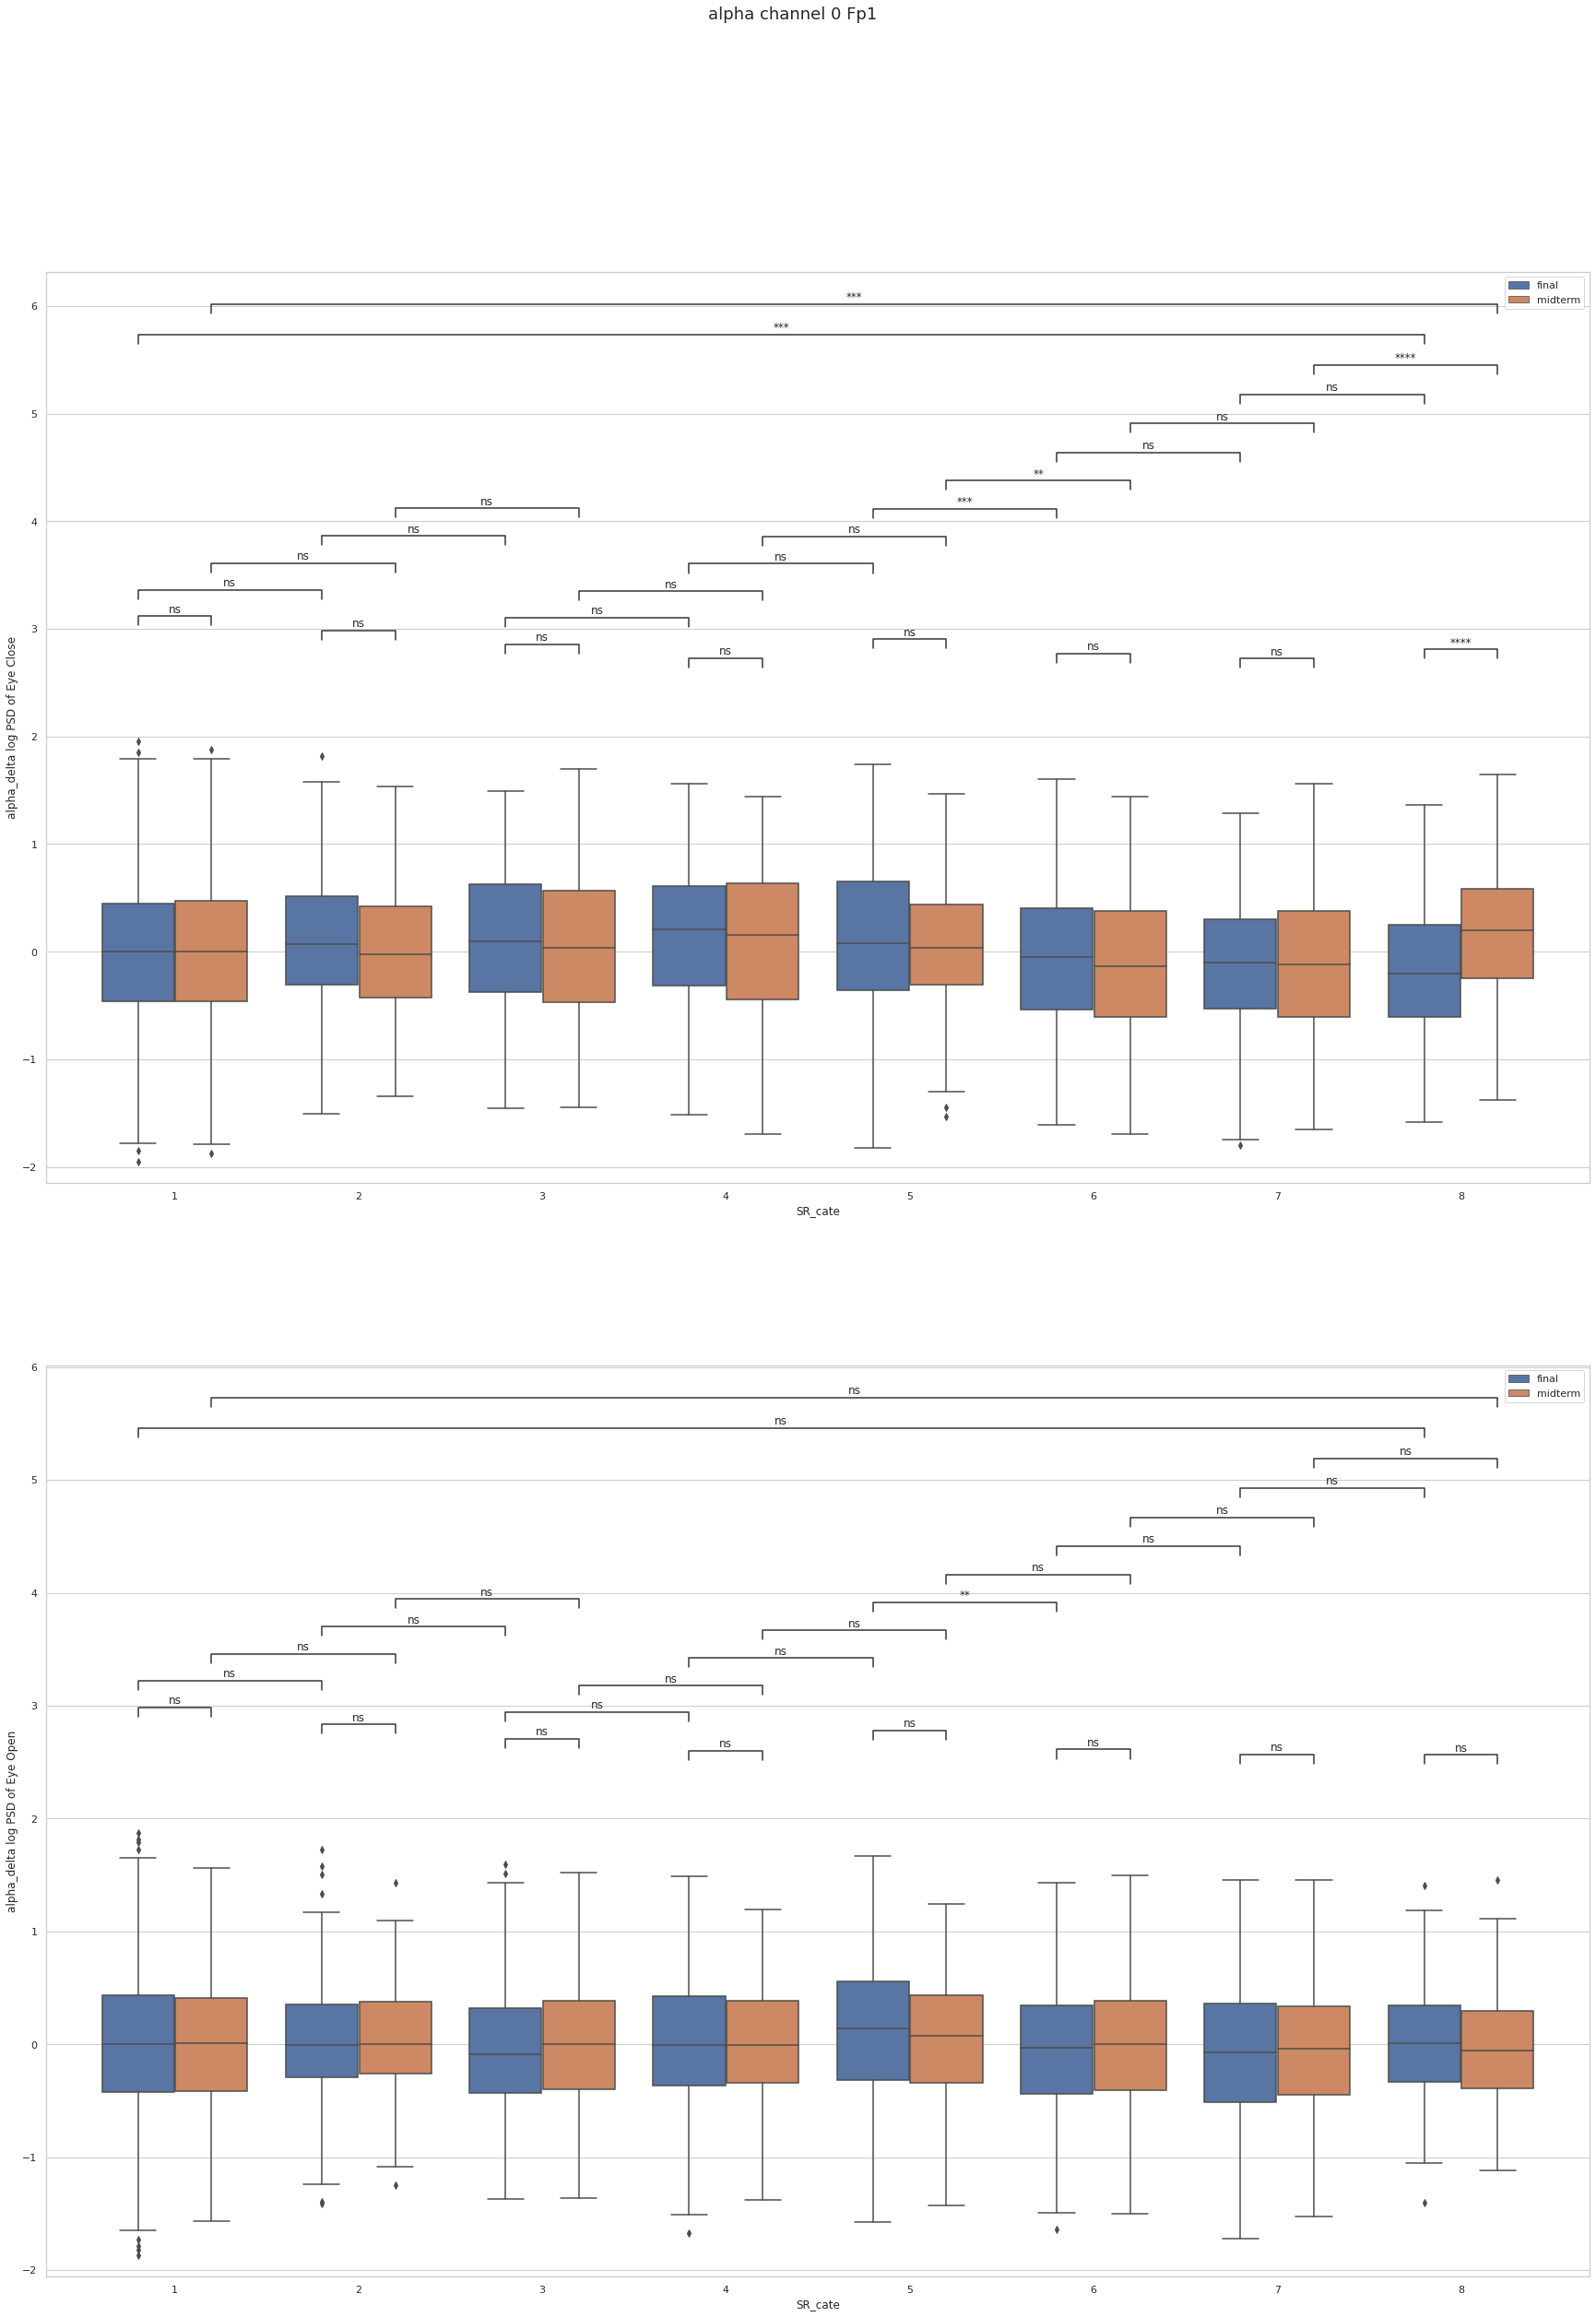

In [10]:
# draw the comparisons in Every Channel
import warnings
warnings.filterwarnings('ignore')
model_type = 'XGBRegressor'
epoch = get_fake_epoch(folder_name = folder_name,main_path = main_path,model_type = model_type)
ch_name = epoch.info['ch_names']
box_pairs = [
            (("1","final"  ),("1","midterm")),
            (("2","final"  ),("2","midterm")),
            (("3","final"  ),("3","midterm")),
            (("4","final"  ),("4","midterm")),
            (("5","final"  ),("5","midterm")),
            (("6","final"  ),("6","midterm")),
            (("7","final"  ),("7","midterm")),
            (("8","final"  ),("8","midterm")),

            (("1","final"  ),("2","final"  )),
            (("1","midterm"),("2","midterm")),
            (("2","final"  ),("3","final"  )),
            (("2","midterm"),("3","midterm")),
            (("3","final"  ),("4","final"  )),
            (("3","midterm"),("4","midterm")),
            (("4","final"  ),("5","final"  )),
            (("4","midterm"),("5","midterm")),
            (("5","final"  ),("6","final"  )),
            (("5","midterm"),("6","midterm")),
            (("6","final"  ),("7","final"  )),
            (("6","midterm"),("7","midterm")),
            (("7","final"  ),("8","final"  )),
            (("7","midterm"),("8","midterm")),
            (("8","final"  ),("1","final"  )),
            (("8","midterm"),("1","midterm")),
                        ]

file_path = '/data/xiaowei/social_network/HENU/figs/compare_psd_channel'
if not os.path.exists(file_path): os.makedirs(file_path)
for ib,band in enumerate(EEG_bands.keys()):
    for ch in tqdm(range(31),desc = f"{band}"):
        band_ch_df = pd.DataFrame(columns = ['delta_psd','term','eye','SR','sA','sB'])
        for term in ['final','midterm']:
            for event in ['eye_close','eye_open']:
                for sA in used_id:
                    for sB in used_id:
                        if not sA == sB:
                            delta_psd = psd_data[f"{term}_{event}_{sA}_{band}"][ch] - psd_data[f"{term}_{event}_{sB}_{band}"][ch]
                            SR = df_sr[sB][sA]
                            band_ch_df = band_ch_df.append({'delta_psd':delta_psd,'term':term,'eye':event,'SR':SR,'sA':sA,'sB':sB},ignore_index=True)
        band_ch_df['SR_cate'] = band_ch_df['SR'].astype(str)
        sns.set(style="whitegrid")
        fig = plt.figure(figsize=(30,40))
        plt.suptitle(f'{band} channel {ch} {ch_name[ch]}', fontsize=18)
        ax = plt.subplot(2,1,1) # eye close
        sns.boxplot(x="SR_cate", y="delta_psd", hue="term", data=band_ch_df[band_ch_df['eye'] == 'eye_close'],order = [f"{i:.0f}" for i in range(1,9)])
        statannot.add_stat_annotation(ax,
                        # plot='barplot',
                        data=band_ch_df[band_ch_df['eye'] == 'eye_close'],x="SR_cate", y="delta_psd", hue="term",order = [f"{i:.0f}" for i in range(1,9)],
                        box_pairs= box_pairs,test="t-test_ind",text_format="star",loc='inside'
                        ,line_offset=0.02,comparisons_correction=None,use_fixed_offset=True,
                        line_offset_to_box=0.25,verbose = 0,
                    )
        plt.legend(loc='best')
        plt.ylabel(f'{band}_delta log PSD of Eye Close')
        # plt.ylim([-0.5,0.5])
        ax = plt.subplot(2,1,2) # eye open
        sns.boxplot(x="SR_cate", y="delta_psd", hue="term", data=band_ch_df[band_ch_df['eye'] == 'eye_open'],order = [f"{i:.0f}" for i in range(1,9)])
        statannot.add_stat_annotation(ax,
                        # plot='barplot',
                        data=band_ch_df[band_ch_df['eye'] == 'eye_open'],x="SR_cate", y="delta_psd", hue="term",order = [f"{i:.0f}" for i in range(1,9)],
                        box_pairs= box_pairs,test="t-test_ind",text_format="star",loc='inside'
                        ,line_offset=0.02,comparisons_correction=None,use_fixed_offset=True,
                        line_offset_to_box=0.25,verbose = 0,
                    )
        plt.legend(loc='best')
        plt.ylabel(f'{band}_delta log PSD of Eye Open')
        # plt.ylim([-0.5,0.5])
        plt.savefig(f"{file_path}/{band}_ch{ch}_{ch_name[ch]}.png", dpi=1000, bbox_inches='tight')
        plt.close()

In [ ]:
# calculate the difference between 2 subjects
# Compare beta of the Significant channels
stat_band = []
file_path = '/data/xiaowei/social_network/HENU/figs/stats'
if not os.path.exists(file_path): os.makedirs(file_path)
for ib,band in enumerate(EEG_bands.keys()):
    coef = dict()
    coef_real = dict()
    p_real = dict()
    for term in ['final','midterm']:
        for event in ['eye_close','eye_open']:
            delta_psd = []
            SR_scale = []
            for sA in tqdm(used_id,desc = f"{term}_{event}_{band}"):
                for sB in used_id:
                    if not sA == sB:
                        delta_psd.append(psd_data[f"{term}_{event}_{sA}_{band}"] - psd_data[f"{term}_{event}_{sB}_{band}"])
                        SR_scale.append(df_sr[sB][sA])
            delta_psd = np.stack(delta_psd)
            c = []
            c_real = []
            p = []
            for ch in range(delta_psd.shape[1]):
                stats = pg.linear_regression(delta_psd[:,ch],SR_scale)
                c.append(stats['coef'].values[1] if stats['pval'].values[1:] < 0.05 else 0.)
                c_real.append(stats['coef'].values[1:])
                p.append(stats['pval'].values[1:])
            
            coef[f'{term}_{event}'] = np.array(c)
            coef_real[f'{term}_{event}'] = np.array(c_real)
            p_real[f'{term}_{event}'] = np.array(p)

    for term in ['final','midterm']:
        for event in ['eye_close','eye_open']:
            save_path = os.path.join(file_path,f"{term}_{event}_{band}_psd.png")
            if np.sum(coef[f'{term}_{event}']) != 0:
                draw_topo_band(coef[f'{term}_{event}'],f'{term}_{event}_{band}',epoch,save_path,vmin = -0.2,vmax = 0.6)

    for event in ['eye_close','eye_open']:
        save_path = os.path.join(file_path,f"{event}_{band}_F-M.png")
        term_coef = coef[f'final_{event}']-coef[f'midterm_{event}']
        draw_topo_band(term_coef.reshape(-1),f'{event}_{band}',epoch,save_path,vmin = -0.35,vmax = 0.2)
        
    idx = 0
    coef_df = pd.DataFrame(columns=['beta','term','event','ch'])
    for term in ['final','midterm']:
        for event in ['eye_close','eye_open']:
            for ch in range(coef_real[f'{term}_{event}'].shape[0]):
                if p_real[f'{term}_{event}'][ch] < 0.05:
                    coef_df = coef_df.append({'beta':np.squeeze(coef_real[f'{term}_{event}'][ch]),'term':term,'event':event,'ch':ch},ignore_index=True)
                else:
                    coef_df = coef_df.append({'beta':0.,'term':term,'event':event,'ch':ch},ignore_index=True)
    # change the type of coef_df['beta'] to numeric
    coef_df['beta'] = coef_df['beta'].astype(float)
    stat = pg.rm_anova(data=coef_df, dv='beta', within=['term','event'],subject = 'ch',detailed=True,effsize='np2')
    stat['band'] = [band for i in range(stat.shape[0])]
    stat['diff'] = np.stack([coef_real['final_eye_close'].mean()+coef_real['final_eye_open'].mean()-coef_real['midterm_eye_close'].mean()-coef_real['midterm_eye_open'].mean(),
                    coef_real['final_eye_close'].mean()+coef_real['midterm_eye_close'].mean()-coef_real['final_eye_open'].mean()-coef_real['midterm_eye_open'].mean(),
                    np.NAN])
    stat['diff_item'] = ['f-m','c-o','n/a']
    stat_band.append(stat)
stat_band = pd.concat(stat_band,axis = 0)
stat_band.to_csv(os.path.join(file_path,'stat_band_only_significant.csv'))

In [ ]:
# calculate the difference between 2 subjects
# Compare the original beta
stat_band = []
file_path = '/data/xiaowei/social_network/HENU/figs/stats'
if not os.path.exists(file_path): os.makedirs(file_path)
for ib,band in enumerate(EEG_bands.keys()):
    coef = dict()
    coef_real = dict()
    p_real = dict()
    for term in ['final','midterm']:
        for event in ['eye_close','eye_open']:
            delta_psd = []
            SR_scale = []
            for sA in tqdm(used_id,desc = f"{term}_{event}_{band}"):
                for sB in used_id:
                    if not sA == sB:
                        delta_psd.append(psd_data[f"{term}_{event}_{sA}_{band}"] - psd_data[f"{term}_{event}_{sB}_{band}"])
                        SR_scale.append(df_sr[sB][sA])
            delta_psd = np.stack(delta_psd)
            c = []
            c_real = []
            p = []
            for ch in range(delta_psd.shape[1]):
                stats = pg.linear_regression(delta_psd[:,ch],SR_scale)
                c.append(stats['coef'].values[1] if stats['pval'].values[1:] < 0.05 else 0.)
                c_real.append(stats['coef'].values[1:])
                p.append(stats['pval'].values[1:])
            
            coef[f'{term}_{event}'] = np.array(c)
            coef_real[f'{term}_{event}'] = np.array(c_real)
            p_real[f'{term}_{event}'] = np.array(p)

    for term in ['final','midterm']:
        for event in ['eye_close','eye_open']:
            save_path = os.path.join(file_path,f"{term}_{event}_{band}_psd.png")
            if np.sum(coef[f'{term}_{event}']) != 0:
                draw_topo_band(coef[f'{term}_{event}'],f'{term}_{event}_{band}',epoch,save_path,vmin = 0,vmax = 0.6)
    idx = 0
    coef_df = pd.DataFrame(columns=['beta','term','event','ch'])
    for term in ['final','midterm']:
        for event in ['eye_close','eye_open']:
            for ch in range(coef_real[f'{term}_{event}'].shape[0]):
                coef_df = coef_df.append({'beta':np.squeeze(coef_real[f'{term}_{event}'][ch]),'term':term,'event':event,'ch':ch},ignore_index=True)
    # change the type of coef_df['beta'] to numeric
    coef_df['beta'] = coef_df['beta'].astype(float)
    stat = pg.rm_anova(data=coef_df, dv='beta', within=['term','event'],subject = 'ch',detailed=True,effsize='np2')
    stat['band'] = [band for i in range(stat.shape[0])]
    stat_band.append(stat)
stat_band = pd.concat(stat_band,axis = 0)
stat_band.to_csv(os.path.join(file_path,'stat_band_or.csv'))

In [ ]:
# Corr comparison
# draw the comparisons in Every Channel via corr
# load psd data
folder_name = 'S42_C30_330_F1_40_N50_E2_Raverage'
data_path = os.path.join(main_path,'EEG_features',folder_name)
psd_files = [f for f in os.listdir(data_path) if 'psd' in f]
used_id = np.unique([int(f[f.find('_psd')-4:f.find('_psd')]) for f in psd_files])
df_sr = pd.read_excel('/data/xiaowei/social_network/HENU/data/survey_data/Social_network_V2.xlsx', index_col=0, header=0)
EEG_bands = dict(alpha = [8,14],beta = [14,30],theta = [4,8],gamma = [30,40],delta = [1,4])

psd_data = {}
for term in ['final','midterm']:
    for event in ['eye_close','eye_open']:
        for subj in tqdm(used_id,desc = f"{term}_{event}_psd"):
            psd = np.log(loadpkl(os.path.join(data_path,f"{term}_{event}_{subj}_psd.pkl"))[0]).mean(0) # (31,78)
            psd_data[f"{term}_{event}_{subj}"] = psd # (31,78)
# standardize psd data
psd_data_mean = np.stack([psd for key,psd in psd_data.items()]).mean()
psd_data_std = np.stack([psd for key,psd in psd_data.items()]).std()
for key,psd in psd_data.items():
    psd_data[key] = (psd-psd_data_mean)/psd_data_std
import warnings
warnings.filterwarnings('ignore')
model_type = 'XGBRegressor'
file_path = '/data/xiaowei/social_network/HENU/figs/compare_psd_channel_corr'
if not os.path.exists(file_path): os.makedirs(file_path)
epoch = get_fake_epoch(folder_name = folder_name,main_path = main_path,model_type = model_type)
ch_name = epoch.info['ch_names']
box_pairs = [
            (("1","final"  ),("1","midterm")),
            (("2","final"  ),("2","midterm")),
            (("3","final"  ),("3","midterm")),
            (("4","final"  ),("4","midterm")),
            (("5","final"  ),("5","midterm")),
            (("6","final"  ),("6","midterm")),
            (("7","final"  ),("7","midterm")),
            (("8","final"  ),("8","midterm")),

            (("8","final"  ),("1","final"  )),
            (("8","midterm"),("1","midterm")),
                        ]


for ch in tqdm(range(31),desc = f"channel..."):
    band_ch_df = pd.DataFrame(columns = ['corr','term','eye','SR','sA','sB'])
    for term in ['final','midterm']:
        for event in ['eye_close','eye_open']:
            for sA in used_id:
                for sB in used_id:
                    if not sA == sB:
                        corr = np.corrcoef(psd_data[f"{term}_{event}_{sA}"][ch],psd_data[f"{term}_{event}_{sB}"][ch])[0,1]
                        SR = df_sr[sB][sA]
                        band_ch_df = band_ch_df.append({'corr':corr,'term':term,'eye':event,'SR':SR,'sA':sA,'sB':sB},ignore_index=True)
    band_ch_df['SR_cate'] = band_ch_df['SR'].astype(str)
    sns.set(style="whitegrid")
    fig = plt.figure(figsize=(30,30))
    plt.suptitle(f'channel {ch} {ch_name[ch]}', fontsize=18)
    ax = plt.subplot(2,1,1) # eye close
    sns.boxplot(x="SR_cate", y="corr", hue="term", data=band_ch_df[band_ch_df['eye'] == 'eye_close'],order = [f"{i:.0f}" for i in range(1,9)])
    statannot.add_stat_annotation(ax,
                    # plot='barplot',
                    data=band_ch_df[band_ch_df['eye'] == 'eye_close'],x="SR_cate", y="corr", hue="term",order = [f"{i:.0f}" for i in range(1,9)],
                    box_pairs= box_pairs,test="t-test_ind",text_format="star",loc='inside'
                    ,line_offset=0.02,comparisons_correction=None,use_fixed_offset=True,
                    line_offset_to_box=0.25,verbose = 0,
                )
    plt.legend(loc='best')
    plt.ylabel(f'corr of Eye Close')
    # plt.ylim([-0.5,0.5])
    ax = plt.subplot(2,1,2) # eye open
    sns.boxplot(x="SR_cate", y="corr", hue="term", data=band_ch_df[band_ch_df['eye'] == 'eye_open'],order = [f"{i:.0f}" for i in range(1,9)])
    statannot.add_stat_annotation(ax,
                    # plot='barplot',
                    data=band_ch_df[band_ch_df['eye'] == 'eye_open'],x="SR_cate", y="corr", hue="term",order = [f"{i:.0f}" for i in range(1,9)],
                    box_pairs= box_pairs,test="t-test_ind",text_format="star",loc='inside'
                    ,line_offset=0.02,comparisons_correction = 'bonferroni',use_fixed_offset=True,
                    line_offset_to_box=0.25,verbose = 0,
                )
    plt.legend(loc='best')
    plt.ylabel(f'corr of Eye Open')
    # plt.ylim([-0.5,0.5])
    plt.savefig(f"{file_path}/ch{ch}_{ch_name[ch]}.png", dpi=300, bbox_inches='tight')
    plt.close()

In [ ]:
# all in one correlation plot channel*freqs
file_path = '/data/xiaowei/social_network/HENU/figs/compare_psd_channel_corr'
if not os.path.exists(file_path): os.makedirs(file_path)
band_ch_df = pd.DataFrame(columns = ['corr','term','eye','SR','sA','sB'])
for term in ['final','midterm']:
    for event in ['eye_close','eye_open']:
        for sA in tqdm(used_id,desc = f"{term}_{event}..."):
            for sB in used_id:
                if not sA == sB:
                    corr = np.corrcoef(psd_data[f"{term}_{event}_{sA}"].reshape(-1),psd_data[f"{term}_{event}_{sB}"].reshape(-1))[0,1]
                    SR = df_sr[sB][sA]
                    band_ch_df = band_ch_df.append({'corr':corr,'term':term,'eye':event,'SR':SR,'sA':sA,'sB':sB},ignore_index=True)
band_ch_df['SR_cate'] = band_ch_df['SR'].astype(str)
sns.set(style="whitegrid")
fig = plt.figure(figsize=(30,30))
plt.suptitle(f'All Corr', fontsize=18)
ax = plt.subplot(2,1,1) # eye close
sns.boxplot(x="SR_cate", y="corr", hue="term", data=band_ch_df[band_ch_df['eye'] == 'eye_close'],order = [f"{i:.0f}" for i in range(1,9)])
statannot.add_stat_annotation(ax,
                # plot='barplot',
                data=band_ch_df[band_ch_df['eye'] == 'eye_close'],x="SR_cate", y="corr", hue="term",order = [f"{i:.0f}" for i in range(1,9)],
                box_pairs= box_pairs,test="t-test_ind",text_format="star",loc='inside'
                ,line_offset=0.02,comparisons_correction=None,use_fixed_offset=True,
                line_offset_to_box=0.25,verbose = 0,
            )
plt.legend(loc='best')
plt.ylabel(f'corr of Eye Close')
# plt.ylim([-0.5,0.5])
ax = plt.subplot(2,1,2) # eye open
sns.boxplot(x="SR_cate", y="corr", hue="term", data=band_ch_df[band_ch_df['eye'] == 'eye_open'],order = [f"{i:.0f}" for i in range(1,9)])
statannot.add_stat_annotation(ax,
                # plot='barplot',
                data=band_ch_df[band_ch_df['eye'] == 'eye_open'],x="SR_cate", y="corr", hue="term",order = [f"{i:.0f}" for i in range(1,9)],
                box_pairs= box_pairs,test="t-test_ind",text_format="star",loc='inside'
                ,line_offset=0.02,comparisons_correction = 'bonferroni',use_fixed_offset=True,
                line_offset_to_box=0.25,verbose = 0,
            )
plt.legend(loc='best')
plt.ylabel(f'corr of Eye Open')
# plt.ylim([-0.5,0.5])
plt.savefig(f"{file_path}/All_in_one.png", dpi=300, bbox_inches='tight')
plt.close()